In [ ]:
! pip install pandas cv2 pytorch numpy PIL 

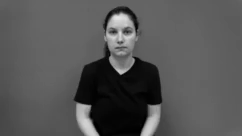

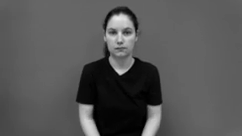

video_id    69241
label        book
offset          0
length         38
Name: 0, dtype: object


In [ ]:
import pandas as pd
import cv2
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader
from IPython import display
import torch
import time
from PIL import Image

DEVICE = 'cuda'

class VideoDataset(Dataset):
    def __init__(self, annotations_file, vid_file, device):
        self.annotations = pd.read_csv(annotations_file)
        labels = self.annotations['label']
        self.label_map = {c: i for i, c in enumerate(set(labels))}
        self.labels = torch.tensor([self.label_map[s] for s in labels]).to(device)
        self.cap = cv2.VideoCapture(vid_file)
        self.device = device

    def __len__(self):
        return len(self.annotations)
    
    def get_clip(self, start, length):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        
        return np.expand_dims(np.array([self.cap.read()[1][:,:,0] for _ in range(length)]).astype(np.float32), 1)

    def __getitem__(self, idx):
        row = self.annotations.loc[idx]
        return torch.tensor(self.get_clip(row['offset'], row['length'])).to(self.device), self.labels[idx]

def show_frame(frame):
    frame.cpu()
    display.display(Image.fromarray(frame.numpy().astype(np.uint8)))

def play_video(vid: torch.Tensor):
    for frame in vid[:,0,:,:]:
        display.clear_output(wait=True)
        show_frame(frame)
        time.sleep(1/15)
    
def get_first_last(vid):
    frame_start = vid[0][0].cpu()
    frame_end = vid[-1][0].cpu()
    
    show_frame(frame_start)
    show_frame(frame_end)

def stats(i):
    get_first_last(ds[i][0])
    print(ds.annotations.loc[i])
        
ds = VideoDataset('labels.csv', 'wlasl_downsampled', DEVICE)

stats(0)

In [13]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn.utils.rnn as rnn_utils

TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 10

train_i, test_i = train_test_split(
    range(len(ds)),
    stratify=ds.annotations['label'],
    test_size=TEST_SIZE,
    random_state=SEED
    )

torch.manual_seed(SEED)

train_split = Subset(ds, train_i)
test_split = Subset(ds, test_i)

def collate(batch):
    batch.sort(key=lambda x: x[0].size(0), reverse=True)
    videos, labels = zip(*batch)

    lengths = [video.size(0) for video in videos]

    padded_videos = rnn_utils.pack_sequence(videos)

    return padded_videos, torch.stack(labels)

train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, collate_fn=collate)


torch.Size([47, 1910])

In [15]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 1
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, annotations in tqdm(train_batches):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, annotations)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_batches)}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, annotations in test_batches:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += annotations.size(0)
        correct += (predicted == annotations).sum().item()

print(f"Accuracy: {100 * correct / total}%")

100%|██████████| 147/147 [02:47<00:00,  1.14s/it]


Epoch 1/1, Loss: 7.554927388016059
Accuracy: 0.1279317697228145%
